<a href="https://colab.research.google.com/github/yucellgereklioglu/datasciencework/blob/main/2%20Predicting_Optimal_Fertilizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Image
from catboost import CatBoostClassifier
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
data=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')
subm=pd.read_csv('/content/sample_submission.csv')

In [5]:
le=LabelEncoder()
data['Soil Type']=le.fit_transform(data['Soil Type'])
data['Crop Type']=le.fit_transform(data['Crop Type'])

In [6]:
data['Fertilizer Name'] = le.fit_transform(data['Fertilizer Name'])
display(data.head())

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,1,9,36.0,4.0,5.0,4
1,1,27,69,65,4,5,30.0,6.0,18.0,4
2,2,29,63,32,4,5,24.0,12.0,16.0,2
3,3,35,62,54,4,0,39.0,12.0,4.0,0
4,4,35,58,43,3,7,37.0,2.0,16.0,5


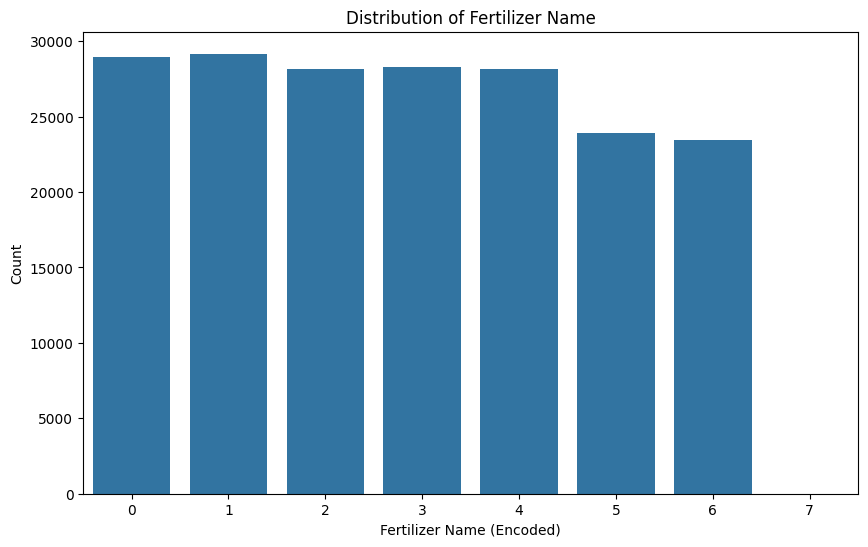

,Fertilizer Name
count,190045.000000
mean,2.858465
std,1.968158
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,7.000000
mode,1.000000


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Fertilizer Name')
plt.title('Distribution of Fertilizer Name')
plt.xlabel('Fertilizer Name (Encoded)')
plt.ylabel('Count')
plt.show()
description = data['Fertilizer Name'].describe()
mode_value = data['Fertilizer Name'].mode()[0]
description['mode'] = mode_value
display(description)

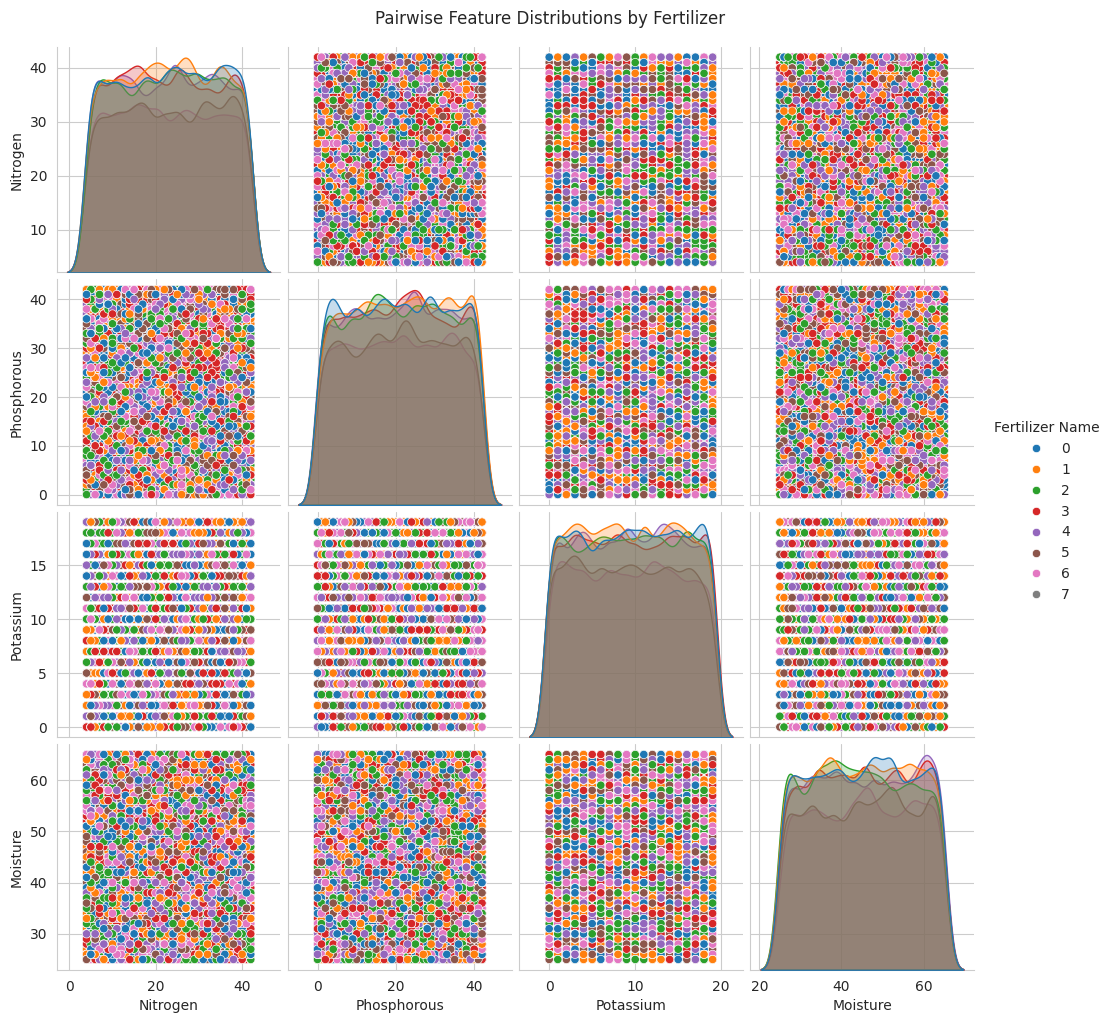

In [37]:
sns.pairplot(data, vars=['Nitrogen', 'Phosphorous', 'Potassium', 'Moisture'],
             hue='Fertilizer Name', palette='tab10', diag_kind='kde')
plt.suptitle('Pairwise Feature Distributions by Fertilizer', y=1.02)
plt.show()

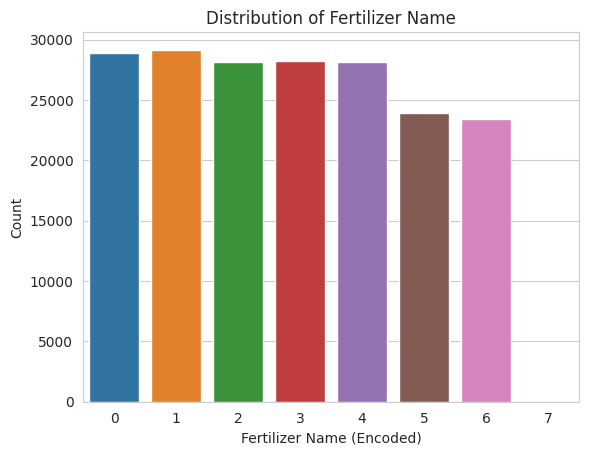

In [39]:
sns.countplot(data=data, x='Fertilizer Name', palette='tab10')
plt.title('Distribution of Fertilizer Name')
plt.xlabel('Fertilizer Name (Encoded)')
plt.ylabel('Count')
plt.show()

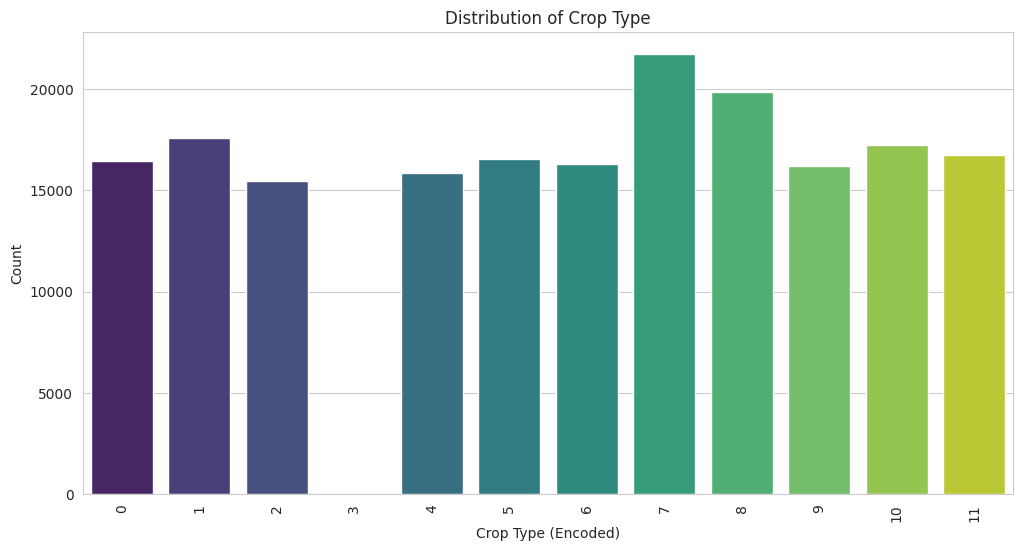

In [41]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='Crop Type', palette='viridis')
plt.title('Distribution of Crop Type')
plt.xlabel('Crop Type (Encoded)')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

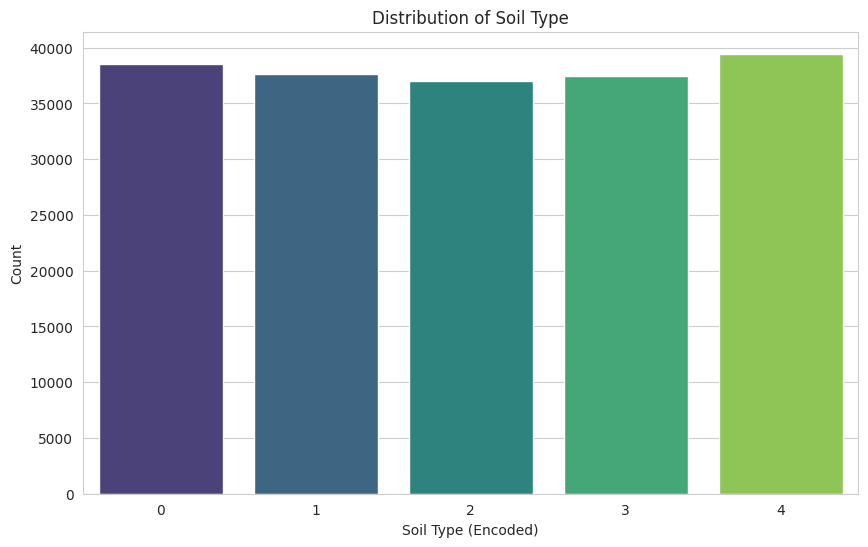

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Soil Type', palette='viridis')
plt.title('Distribution of Soil Type')
plt.xlabel('Soil Type (Encoded)')
plt.ylabel('Count')
plt.show()

In [8]:
X = data.drop('Fertilizer Name', axis=1)
y = data['Fertilizer Name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)


Now that the `catboost` library is installed, you can run the cell with the model training code again.

In [10]:
# Impute missing values with the mean in training and testing sets
for col in ['Nitrogen', 'Potassium', 'Phosphorous']:
    mean_val = X_train[col].mean()
    X_train[col].fillna(mean_val, inplace=True)
    X_test[col].fillna(mean_val, inplace=True)

print("Missing values in X_train after imputation:")
print(X_train[['Nitrogen', 'Potassium', 'Phosphorous']].isnull().sum())

print("\nMissing values in X_test after imputation:")
print(X_test[['Nitrogen', 'Potassium', 'Phosphorous']].isnull().sum())

Missing values in X_train after imputation:
Nitrogen       0
Potassium      0
Phosphorous    0
dtype: int64

Missing values in X_test after imputation:
Nitrogen       0
Potassium      0
Phosphorous    0
dtype: int64


In [17]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    depth=2,
    learning_rate=0.02,
    early_stopping_rounds=30,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    l2_leaf_reg=0.15,
    bootstrap_type="Bayesian",
    use_best_model=True,
    bagging_temperature=0.25,
    random_strength=0.5,
    random_state=42,
    border_count=62,
    verbose=100,
    cat_features=['Soil Type', 'Crop Type']
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    verbose=100
)

0:	learn: 2.0764550	test: 2.0764579	best: 2.0764579 (0)	total: 312ms	remaining: 30.8s
99:	learn: 1.9586075	test: 1.9589278	best: 1.9589278 (99)	total: 29.2s	remaining: 0us

bestTest = 1.958927755
bestIteration = 99



In [20]:
y_pred=model.predict(X_test)
y_probabilty=model.predict_proba(X_test)

In [23]:
def calculate_map_at_k(y_true, y_pred_proba, k=5):
    y_true = np.array(y_true)
    top_k_preds = np.argsort(y_probabilty, axis=1)[:, ::-1][:, :k]

    scores = []
    for i in range(len(y_true)):
        true_label = y_true[i]
        pred_labels = top_k_preds[i]
        if true_label in pred_labels:
            rank = np.where(pred_labels == true_label)[0][0] + 1
            scores.append(1.0 / rank)
        else:

            scores.append(0.0)
    return np.mean(scores)

map5_score = calculate_map_at_k(y_test, y_probabilty, k=5)
map3_score = calculate_map_at_k(y_test, y_probabilty, k=3)

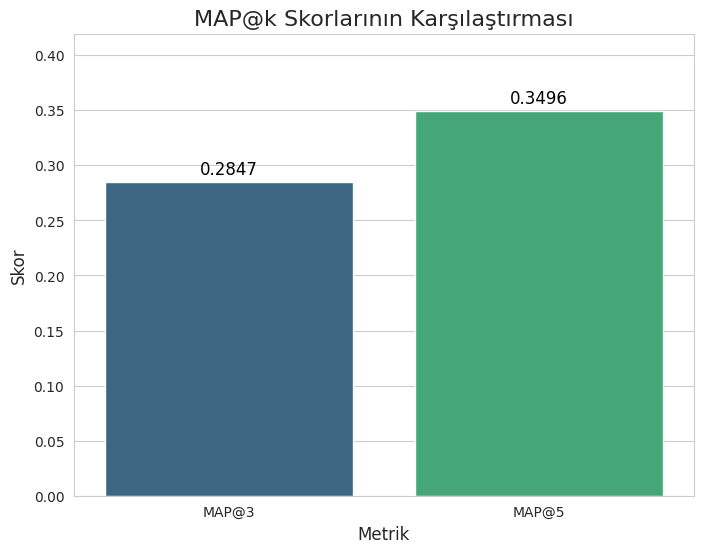

In [33]:
metrics = ['MAP@3', 'MAP@5']
scores = [map3_score, map5_score]
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=metrics, y=scores, palette='viridis')
plt.title('MAP@k Skorlarının Karşılaştırması', fontsize=16)
plt.xlabel('Metrik', fontsize=12)
plt.ylabel('Skor', fontsize=12)
plt.ylim(0, max(scores) * 1.2)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'),
                (
                p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points',
                   fontsize=12,
                   color='black')
plt.show()

In [24]:
print(f"MAP@5 Score: {map5_score}")
print(f"MAP@3 Score: {map3_score}")

MAP@5 Score: 0.3496071105966131
MAP@3 Score: 0.2846869601059398


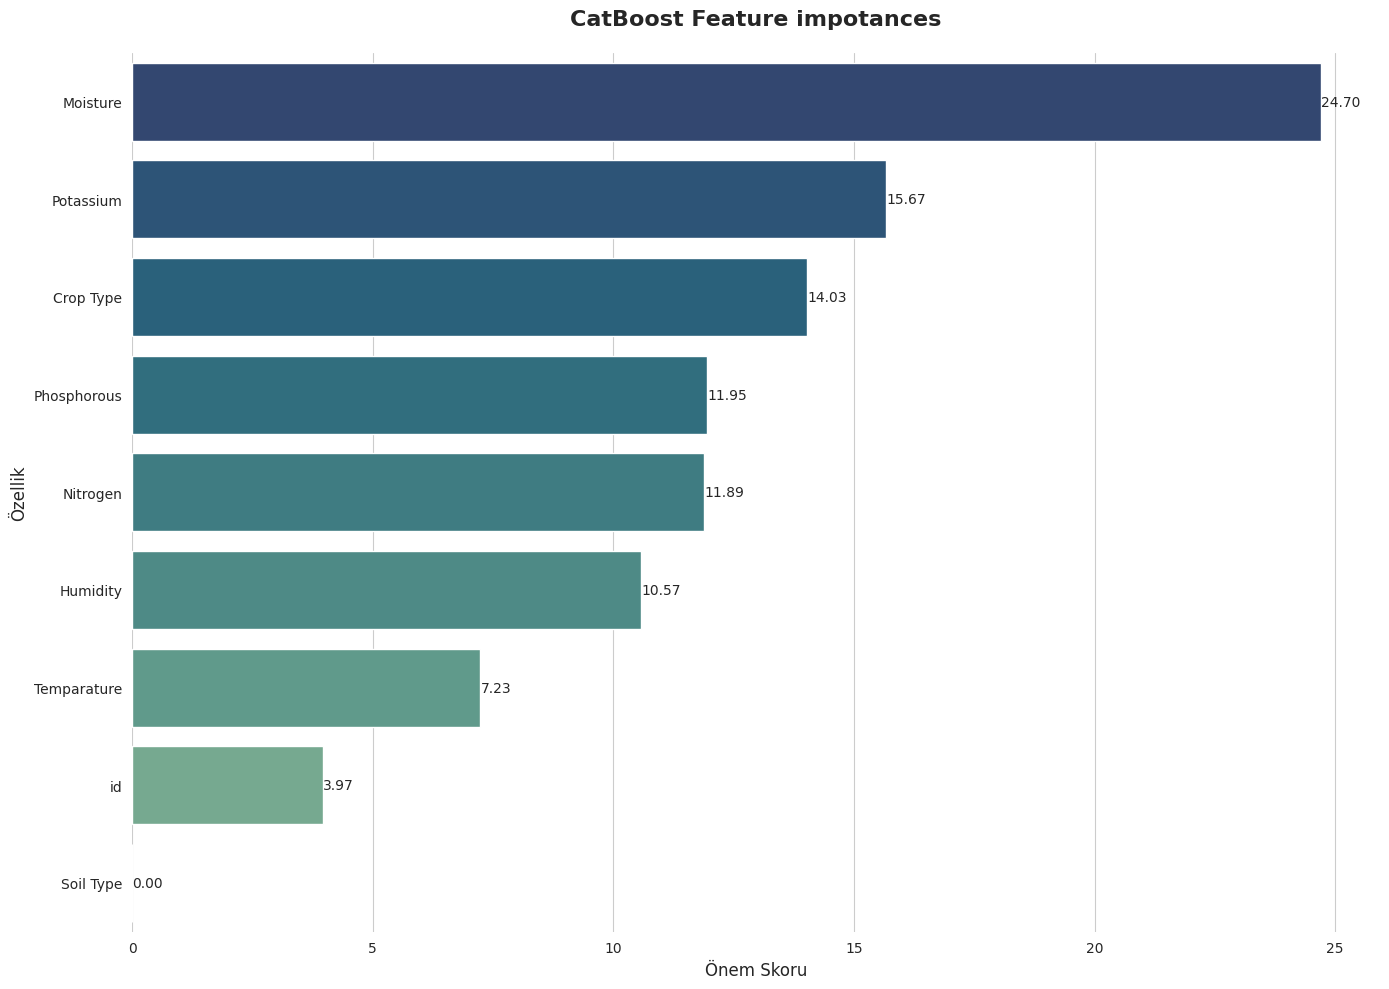

,Feature Id,Importances
0,Moisture,24.695478
1,Potassium,15.669586
2,Crop Type,14.025756
3,Phosphorous,11.947114
4,Nitrogen,11.892119
5,Humidity,10.569315
6,Temparature,7.234655
7,id,3.965978
8,Soil Type,0.000000


In [26]:
feature_importances = model.get_feature_importance(prettified=True)
feature_importances = feature_importances.sort_values(by='Importances', ascending=False)
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))
barplot = sns.barplot(
    x='Importances',
    y='Feature Id',
    data=feature_importances,
    palette='crest_r'
)
sns.despine(left=True, bottom=True)
plt.title('CatBoost Feature impotances', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Önem Skoru', fontsize=12)
plt.ylabel('Özellik', fontsize=12)
for p in barplot.patches:
    width = p.get_width()
    plt.text(width + 0.01,
             p.get_y() + p.get_height() / 2,
             f'{width:.2f}',
             va='center')
plt.tight_layout()
plt.show()
display(feature_importances)